In [ ]:
#hide
%reload_ext autoreload
%autoreload 2
import point_to_box.utils as utils
import point_to_box.data as data
import point_to_box.model as model
from pathlib import Path
import random
import numpy as np
import matplotlib.pyplot as plt
import json
import torch
import glob
import os
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.optim as opt

# Point-to-box

> A set of models, tools, and tutorials for the automation of annotating individual objects in images.

This file will become your README and also the index of your documentation.

## Install

`pip install point_to_box`

## How to use

**WORK IN PROGRESS**

The library performs three major functions:

- converting COCO-style object detection images and annotations into point-to-box style images and annotations
- training prompted class-agnostic, single-object localization models
- providing access to models pretrained on COCO data

### Manipulating data

#### Converting data

The `point_to_box.data` module can transform COCO object-detection style images and annotations into point-to-box style images and annotations using a `ConversionDataset`

In [ ]:
#hide
SRC = Path('../../data/val2017/')
DST = Path('../../converted_data')
ANNOS = 'instances_val2017.json'

In [ ]:
#hide_output
dataset = data.ConversionDataset(data_path = SRC, anno_fname = ANNOS,
                                 dst_path = DST, img_size = 224, n = 3)

loading annotations into memory...
Done (t=0.61s)
creating index...
index created!


In [ ]:
#hide
# 'efficientnet-b0': (1.0, 1.0, 224, 0.2),
# 'efficientnet-b1': (1.0, 1.1, 240, 0.2),
# 'efficientnet-b2': (1.1, 1.2, 260, 0.3),
# 'efficientnet-b3': (1.2, 1.4, 300, 0.3),
# 'efficientnet-b4': (1.4, 1.8, 380, 0.4),
# 'efficientnet-b5': (1.6, 2.2, 456, 0.4),
# 'efficientnet-b6': (1.8, 2.6, 528, 0.5),
# 'efficientnet-b7': (2.0, 3.1, 600, 0.5),
# 'efficientnet-b8': (2.2, 3.6, 672, 0.5),
# 'efficientnet-l2': (4.3, 5.3, 800, 0.5),

A ConversionDataset can turn images with box annotations like this:

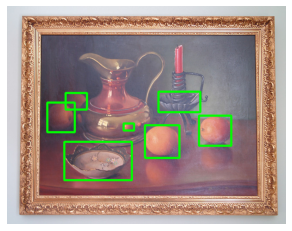

In [ ]:
#hide_input
img, bboxs, prompts, cats = dataset.load_img(184791)
img_w_boxes=utils.draw_rect(np.array(img), np.reshape(np.array(bboxs), (-1, 4)))
plt.imshow(img_w_boxes)
plt.axis('off')
plt.show()

Into individual images with point-to-box style annotations like this:

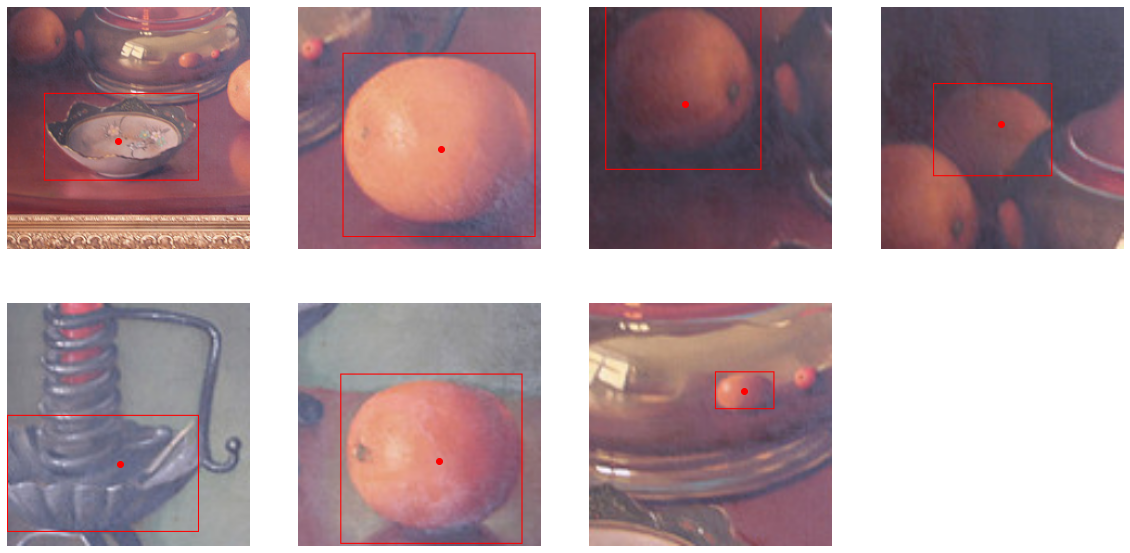

In [ ]:
#hide_input
# crop objects into individual images
imgs_crop, boxs_crop, cntrs_crop = dataset.crop_objs(img, bboxs, prompts, resize = True, img_size=224)

# plot
fig = plt.figure(figsize = (20,10))
for i in range(1, len(imgs_crop) + 1):
    crop_img_w_box = utils.draw_rect(imgs_crop[i-1], 
                                     np.array([boxs_crop[i-1]]))
    fig.add_subplot(2,4,i)
    plt.imshow(crop_img_w_box)
    plt.plot(cntrs_crop[i-1][0], cntrs_crop[i-1][1], 'ro')
    plt.axis('off')
plt.show()

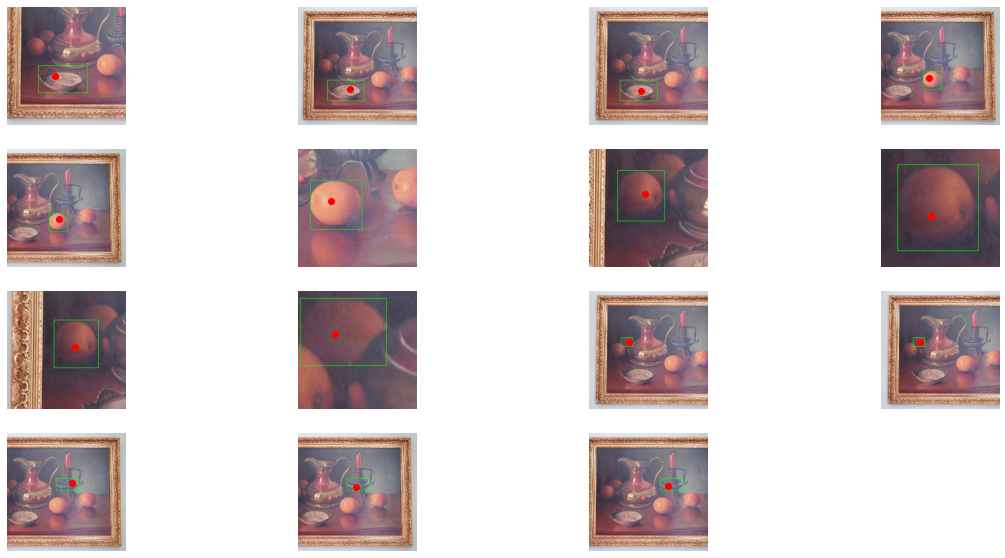

In [ ]:
#hide
# crop objects into individual images
imgs_crop, boxs_crop, prompts_crop = dataset.crop_objs(img, bboxs, prompts, resize = True, img_size=224)
rows, cols = 4, 4
# plot
fig = plt.figure(figsize = (20,10))
for i in range(1, min(len(imgs_crop) + 1, rows*cols)):
    crop_img_w_box = utils.draw_rect(imgs_crop[i-1], 
                                     np.array([boxs_crop[i-1]]))
    fig.add_subplot(rows,cols,i)
    plt.imshow(crop_img_w_box)
    plt.plot(prompts_crop[i-1][0], prompts_crop[i-1][1], 'ro')
    plt.axis('off')
plt.show()

The ConversionDataset class has a `convert` method to convert individual images one at a time as well as a `convert_all` method to process all (or a percentage) of the images.

In [ ]:
#hide_output
# dataset.convert(184791)
dataset.convert_all(cord_format = 'corner_ofst_frac')

100%|██████████| 5000/5000 [05:41<00:00, 14.65it/s]


The `to_json()` method writes the new annotations to file and can split the data into training and validation partitions using the `pct` argument. If no percentage is specified the dataset remains unparitioned and is written to a single directory.

In [ ]:
#hide_output
dataset.to_json(pct = 0.15)

Moving val images: 100%|██████████| 16351/16351 [00:04<00:00, 3667.56it/s]


#### Using data

The `point_to_box.data` module contains a `PTBDataset` class designed in the PyTorch style so it can be used with a PyTorch `DataLoader`.

In [ ]:
#hide_output
ptbdata = data.PTBDataset(
    root = DST/'train',
    annos = DST/('train/train_individual_'+ANNOS))

ptbloader = torch.utils.data.DataLoader(dataset = ptbdata, batch_size = 8, shuffle = True)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [ ]:
# temp_json = json.load(open(DST/('temp/train/train_individual_'+ANNOS)))
# temp_json

Plotting a batch of images from our converted data let's us confirm that the cropping and box coordinate conversion works as we expect it to.

In [ ]:
#hide
dl = iter(ptbloader)

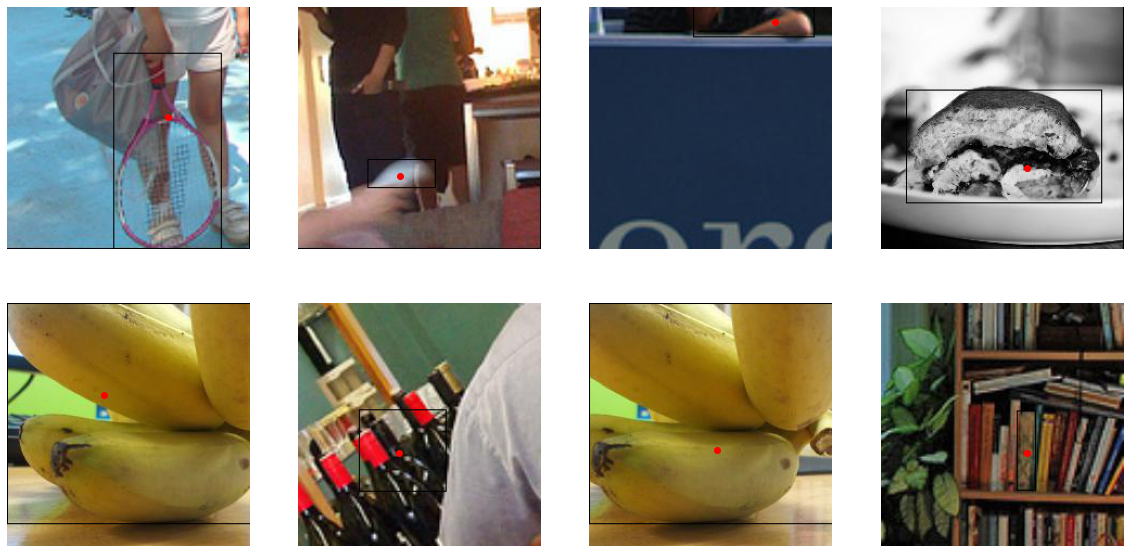

In [ ]:
#hide_input
batch_imgs, batch_boxes = next(dl)
# batch_imgs, batch_boxes = batch_imgs.numpy(), batch_boxes.numpy()
fig = plt.figure(figsize = (20,10))
for i, (img, box) in enumerate(zip(batch_imgs, batch_boxes)):
    img_only = img[:3,:,:].permute(1,2,0).numpy()
    mask = img[3:,:,:].permute(1,2,0).numpy()
    ycntr, xcntr, _ = np.where(mask == mask.max())
    box = np.array([box.numpy()])
    crop_img_w_box = utils.draw_rect(img_only, box, 
                                     box_format = 'corner_ofst_frac',
                                     color = [(0,255,0)])
#     print(crop_img_w_box*255)
    fig.add_subplot(2,4,i+1)
    plt.imshow((crop_img_w_box*255).astype('uint8'))
    plt.plot(xcntr, ycntr, 'ro')
    plt.axis('off')
plt.show()

### Training models

In [ ]:
#hide
DST = Path('../../converted_data')
ANNOS = 'instances_val2017.json

In [ ]:
#hide
norm_format = 'img_net_4ch'
# box_format = 'corner_ofst_frac'
norm_chnls = 3

if norm_format == 'img_net':
    norm_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
elif norm_format == 'img_net_4ch':
    norm_stats = ([0.485, 0.456, 0.406, 1.993e-05], 
                  [0.229, 0.224, 0.225, 0.0045])
    norm_chnls = 4
elif norm_format == 'surfer':
    norm_stats = ([5.4271e-01, 5.7049e-01, 5.8811e-01],
                  [0.0892, 0.0858, 0.0831])
elif norm_format == 'surfer_4ch':
    norm_stats = ([5.4271e-01, 5.7049e-01, 5.8811e-01, 1.9930e-05],
                  [0.0892, 0.0858, 0.0831, 0.0045])
    norm_chnls = 4

data_transforms = {
    'train': transforms.Compose([
#         transforms.RandomResizedCrop(224),
#         transforms.RandomHorizontalFlip(),
#         transforms.ToTensor(),
        transforms.Normalize(*norm_stats)
    ]),
    'val': transforms.Compose([
#         transforms.Resize(256),
#         transforms.CenterCrop(224),
#         transforms.ToTensor(),
        transforms.Normalize(*norm_stats)
    ]),
}

# ptbdata = data.PTBDataset(
#     root = DST/'train',
#     annos = DST/('train/train_individual_'+ANNOS),
#     box_format = 'corner_ofst_frac')


image_datasets = {
    'train': data.PTBDataset(
        root = DST/'train',
        annos = DST/('train/train_individual_'+ANNOS),
        tfms = data_transforms['train'],
        norm_chnls = norm_chnls),
    
    'val': data.PTBDataset(
        root = DST/'val',
        annos = DST/('val/val_individual_'+ANNOS),
        tfms = data_transforms['val'],
        norm_chnls = norm_chnls)
}

batch_sizes = {'train':4,'val':8}

dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_sizes[x],
                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

loading annotations into memory...
Done (t=0.19s)
creating index...
index created!
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


In [ ]:
effloc = model.EfficientLoc(version='efficientnet-b4')

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b4-6ed6700e.pth" to /Users/constantinbaumgartner/.cache/torch/hub/checkpoints/efficientnet-b4-6ed6700e.pth


  0%|          | 0.00/74.4M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b4


In [ ]:
#hide
effloc.model

Sequential(
  (0): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      4, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
    )
    (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
          (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
        )
        (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          48, 12, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          12, 48, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_proje

In [ ]:
#hide
# load test
checkpt = torch.load('../../../temp_model_weights/EfficientLoc-b0-surfers_200e_surfernorm4ch.pth',
                    map_location = effloc.device)
effloc.load(checkpt['model_state_dict'])

In [ ]:
#hide
# save test
effloc.save(DST/'model_save_test.pth')

In [ ]:
#hide
# box coordinate loss functions
# criterion = torch.nn.MSELoss()
# criterion = torch.nn.SmoothL1Loss(reduction = 'sum')
criterion = model.CIoU()

In [ ]:
#hide
# Optimizer
# optimizer = opt.SGD(
#     model.parameters(),
#     lr = 0.001,
#     momentum = 0.9
# )
optimizer = opt.AdamW(effloc.model.parameters())

In [ ]:
#hide

# Learning Rate Scheduler
# Decay LR by a factor of 0.1 every 7 epochs
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)
scheduler = None

num_epochs = 40

In [ ]:
#hide
# trained_model = train_model(
#     model = model, 
#     criterion = criterion, 
#     optimizer = optimizer, 
#     scheduler = scheduler, 
#     num_epochs = num_epochs)

effloc.train(
    dataloaders = dataloaders,
    criterion = criterion,
    optimizer = optimizer,
    num_epochs = num_epochs,
    ds_sizes = dataset_sizes,
    print_every = 10
)

Epoch 1/2
----------
Intermediate loss: 0.041554
Intermediate loss: 0.039954
Intermediate loss: 0.042520
Intermediate loss: 0.052959
Intermediate loss: 0.060165
Intermediate loss: 0.061138
Intermediate loss: 0.049918
-----
train Phase Duration: 1m 22s  Average Loss: 0.049721 in 
-----
Intermediate loss: 0.115189
Intermediate loss: 0.075130
Intermediate loss: 0.057340
Intermediate loss: 0.095920
Intermediate loss: 0.064394
Intermediate loss: 0.084086
Intermediate loss: 0.096052
-----
val Phase Duration: 0m 26s  Average Loss: 0.082627 in 
-----
Epoch 2/2
----------
Intermediate loss: 0.048836
Intermediate loss: 0.044734
Intermediate loss: 0.042781
Intermediate loss: 0.048964
Intermediate loss: 0.039914
Intermediate loss: 0.044340
Intermediate loss: 0.046581
-----
train Phase Duration: 1m 17s  Average Loss: 0.045251 in 
-----
Intermediate loss: 0.107430
Intermediate loss: 0.082926
Intermediate loss: 0.070262
Intermediate loss: 0.094510
Intermediate loss: 0.098226
Intermediate loss: 0.0742

In [ ]:
# b1 liner 100
# Training complete in 49m 22s
# Best val Loss: 0.0359
# EfficientLoc-b1-coco2017val_40e_imgnetnorm4ch_100L.pth
# effloc.save(DST/'EfficientLoc-b1-coco2017val_40e_imgnetnorm4ch_100L.pth')

In [ ]:
# b2 liner 100
# Training complete in 51m 0s
# Best val Loss: 0.0357
# EfficientLoc-b2-coco2017val_40e_imgnetnorm4ch_100L.pth
# effloc.save(DST/'EfficientLoc-b2-coco2017val_40e_imgnetnorm4ch_100L.pth')

In [ ]:
# b3 liner 100
# Training complete in 61m 44s
# Best val Loss: 0.0353

# EfficientLoc-b3-coco2017val_40e_imgnetnorm4ch_100L.pth
# effloc.save(DST/'EfficientLoc-b3-coco2017val_40e_imgnetnorm4ch_100L.pth')

In [ ]:
# b3 linear out_features 
# Training complete in 61m 47s
# Best val Loss: 0.0347

# EfficientLoc-b3-coco2017val_40e_imgnetnorm4ch_4L.pth
# effloc.save(DST/'EfficientLoc-b3-coco2017val_40e_imgnetnorm4ch_4L.pth')

In [ ]:
#hide
effloc.model = torch.nn.DataParallel(effloc.model)

In [ ]:
#hide
checkpt = torch.load(DST/'EfficientLoc-b0-coco2017val_20e_imgnetnorm4ch.pth',
                    map_location = effloc.device)

effloc.load(checkpt['model_state_dict'])

In [ ]:
#hide
val_tmp = dataloaders['val']

val_tmp = iter(val_tmp)

batch = next(val_tmp)

preds = effloc.model(batch[0])

imgs = batch[0]

bboxs = batch[1]

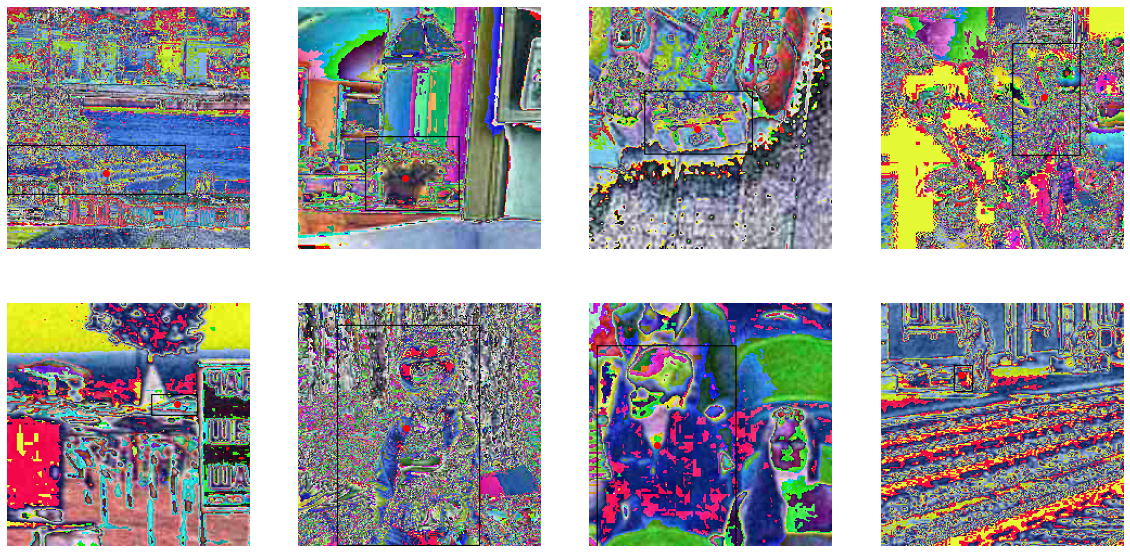

In [ ]:
#hide

##### PLOT BATCH ######

fig = plt.figure(figsize = (20,10))
for i, (img, box) in enumerate(zip(imgs, bboxs)):
    img_only = img[:3,:,:].permute(1,2,0).numpy()
    mask = img[3:,:,:].permute(1,2,0).numpy()
    ycntr, xcntr, _ = np.where(mask == mask.max())
    box = np.array([box.numpy()])
    crop_img_w_box = utils.draw_rect(img_only, box, 
                                     box_format = 'corner_ofst_frac',
                                     color = [(0,0,255)])
#     print(crop_img_w_box*255)
    fig.add_subplot(2,4,i+1)
    plt.imshow((crop_img_w_box*255).astype('uint8'))
    plt.plot(xcntr, ycntr, 'ro')
    plt.axis('off')
plt.show()

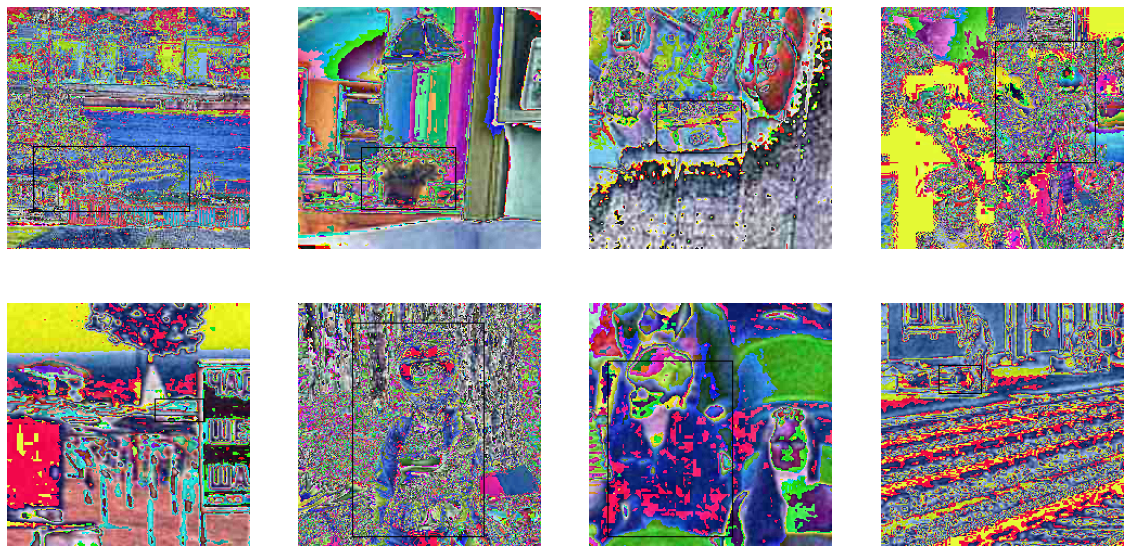

In [ ]:
#hide

##### PLOT PREDS #######

fig = plt.figure(figsize = (20,10))
for i, (img, box) in enumerate(zip(imgs, preds.detach())):
    img_only = img[:3,:,:].permute(1,2,0).numpy()
    mask = img[3:,:,:].permute(1,2,0).numpy()
    ycntr, xcntr, _ = np.where(mask == mask.max())
    box = np.array([box.numpy()])
    crop_img_w_box = utils.draw_rect(img_only, box, 
                                     box_format = 'corner_ofst_frac',
                                     color = [(0,0,255)])
#     print(crop_img_w_box*255)
    fig.add_subplot(2,4,i+1)
    plt.imshow((crop_img_w_box*255).astype('uint8'))
#     plt.plot(xcntr, ycntr, 'ro')
    plt.axis('off')
plt.show()

In [ ]:
#hide
input_var = torch.randn(1,4,224,224, requires_grad = False)

torch.onnx.export(effloc.model.module, input_var, 'effloc_coco2017val_20e.onnx')